<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Dacon_%EC%9E%91%EB%AC%BC_%EB%B3%91%ED%95%B4_%EC%A7%84%EB%8B%A8_detection_train_(yolov5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 농업 환경 변화에 따른 작물 병해 진단 AI 경진대회
1. train : 학습용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.jpg : 이미지 파일

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.json :

	│		├ description 

	│		│	├ image : 이미지 파일 이름

	│		│	├ date : 촬영 날짜

	│		│	├ time : 촬영 시간

	│		│	├ region : 촬영 지역

	│		│	├ height : 이미지 높이

	│		│	├ width : 이미지 너비

	│		│	└  task : 데이터 종류 (질병/해충/병해/정상 구분)

	│		└ annotations

	│				├ disease : 작물 상태 코드

	│				├ crop : 작물 코드

	│				├ area : 작물 촬영 부위

	│				├ grow : 작물의 생육 단계 

	│				├ risk : 질병 피해 정도

	│				├ bbox : 주목 객체 바운딩 박스 (x, y, w, h 형태)

	│				└ part : 병해 부위 바운딩 박스 (x, y, w, h 형태)

	│

	├ 10002

	├ 10003

	└ ...

	[추가] train.csv : train set에 대한 정답 파일

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"




2. test : 평가용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.jpg : 이미지 파일

	│

	├ 10002

	├ 10003

	└ ...



3. sample_submission.csv : 제출용 양식

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"

#1. Ultralytics Yolov5 설치

In [1]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 11212, done.
remote: Total 11212 (delta 0), reused 0 (delta 0), pack-reused 11212
Receiving objects: 100% (11212/11212), 11.11 MiB | 33.18 MiB/s, done.
Resolving deltas: 100% (7759/7759), done.
/content/yolov5
     |████████████████████████████████| 596 kB 6.8 MB/s 
/content


# 2. 데이터 다운로드

In [2]:
!unzip /content/drive/MyDrive/data.zip

Archive:  /content/drive/MyDrive/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [3]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
  inflating: train/55844/55844.csv   
   creating: train/55847/
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.json  
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
   creating: train/55858/
  inflating: train/55858/55858.json  
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.csv   
   creating: train/55870/
  inflating: train/55870/55870.json  
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
   creating: train/55889/
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.jpg   
  inflating: train/55895/55895.csv   
  inflating: train/558

In [39]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import json
import cv2
import matplotlib.pyplot as plt

import os
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import time

#3. 데이터 탐색

In [6]:
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 1s (264 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fron

In [7]:
!jq . /content/train/10027/10027.json > output.json 

In [8]:
!head -200 output.json

{
  "description": {
    "date": "20211126",
    "image": "10027.jpg",
    "task": 2,
    "width": 384,
    "time": "0935",
    "region": 0,
    "height": 512
  },
  "annotations": {
    "area": 3,
    "disease": "b7",
    "grow": 13,
    "bbox": [
      {
        "x": 89.14301990327381,
        "h": 237.8629402281746,
        "y": 162.00396825396825,
        "w": 165.0040302579365
      }
    ],
    "part": [
      {
        "x": 125.57248263888889,
        "h": 78.85906498015873,
        "y": 177.43291170634922,
        "id": 0,
        "w": 32.14364769345238
      },
      {
        "x": 162.8591114831349,
        "h": 57.858568948412696,
        "y": 187.290287078373,
        "id": 1,
        "w": 35.57229662698413
      }
    ],
    "risk": 1,
    "crop": 3
  }
}


In [9]:
train_csv = sorted(glob('/content/train/*/*.csv'))
train_jpg = sorted(glob('/content/train/*/*.jpg'))
train_json = sorted(glob('/content/train/*/*.json'))

crops = []
diseases = []
risks = []
labels = []

# 훈련 데이터 로드
for i in range(len(train_json)):
  with open(train_json[i], 'r') as f:
    sample = json.load(f)
    crop = sample['annotations']['crop']
    disease = sample['annotations']['disease']
    risk = sample['annotations']['risk']
    label = f"{crop}_{disease}_{risk}"

    crops.append(crop)
    diseases.append(disease)
    risks.append
    labels.append(label)

In [10]:
def plot_bbox(img_path, json_path):
  sample_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  draw_img = sample_img.copy()

  with open(json_path, 'r') as f:
    sample = json.load(f)

    bboxes = sample['annotations']['bbox']
    for bbox in bboxes:
      bbox_x = int(bbox['x'])
      bbox_y = int(bbox['y'])
      bbox_h = int(bbox['h'])
      bbox_w = int(bbox['w'])
      cv2.rectangle(draw_img, (bbox_x, bbox_y), (bbox_x + bbox_w, bbox_y + bbox_h), color = (0, 255, 0), thickness = 1)

    parts = sample['annotations']['part']
    for part in parts:
      part_x = int(part['x'])
      part_y = int(part['y'])
      part_w = int(part['w'])
      part_h = int(part['h'])
      cv2.rectangle(draw_img, (part_x, part_y), (part_x + part_w, part_y + part_h), color = (255, 0, 0), thickness = 1 )
  
  plt.figure(figsize = (15, 12))
  plt.subplot(1, 2, 1)
  plt.imshow(sample_img)

  plt.subplot(1, 2, 2)
  plt.imshow(draw_img)

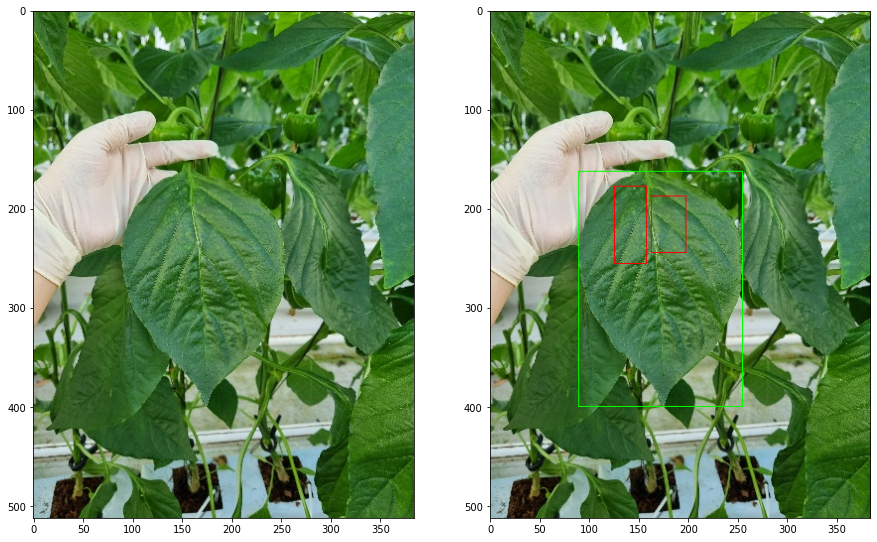

In [11]:
plot_bbox(train_jpg[0], train_json[0])

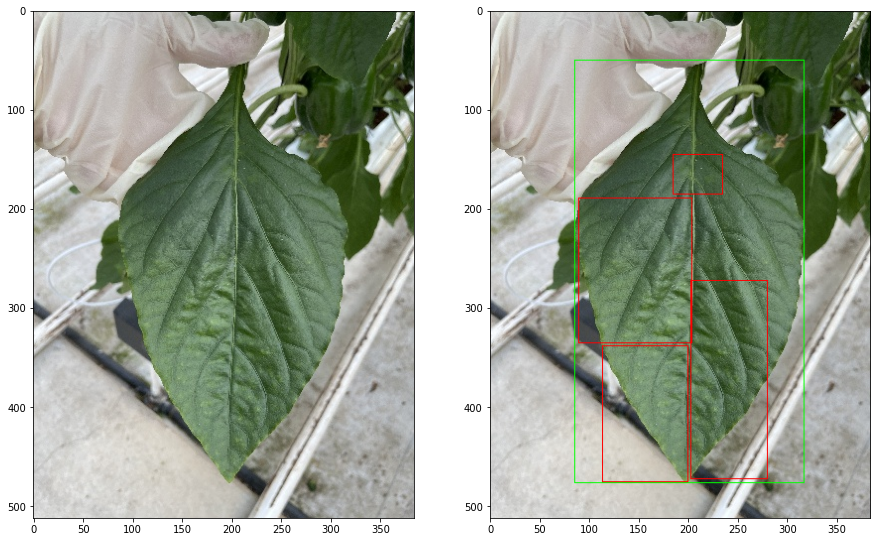

In [12]:
plot_bbox(train_jpg[12], train_json[12])

In [13]:
label_unique = sorted(np.unique(labels))

In [14]:
len(labels), len(label_unique)

(5767, 25)

In [15]:
# Label Encoding
label_unique_encoded = {key:value for key,value in zip(label_unique, range(len(label_unique)))}
label_unique_encoded

{'1_00_0': 0,
 '2_00_0': 1,
 '2_a5_2': 2,
 '3_00_0': 3,
 '3_a9_1': 4,
 '3_a9_2': 5,
 '3_a9_3': 6,
 '3_b3_1': 7,
 '3_b6_1': 8,
 '3_b7_1': 9,
 '3_b8_1': 10,
 '4_00_0': 11,
 '5_00_0': 12,
 '5_a7_2': 13,
 '5_b6_1': 14,
 '5_b7_1': 15,
 '5_b8_1': 16,
 '6_00_0': 17,
 '6_a11_1': 18,
 '6_a11_2': 19,
 '6_a12_1': 20,
 '6_a12_2': 21,
 '6_b4_1': 22,
 '6_b4_3': 23,
 '6_b5_1': 24}

In [16]:
# 문자열을 인코딩된 레이블로 치환
labels_encoded = [label_unique_encoded[k] for k in labels]

In [17]:
val_size = 0.1
val_num = int(len(train_jpg) * val_size)
indexes = np.random.choice(len(train_jpg), val_num, False)

In [18]:
len(indexes)

576

In [19]:
tr_imgs = np.delete(np.array(train_jpg), indexes)
val_imgs = np.array(train_jpg)[indexes]

In [20]:
len(train_jpg), len(tr_imgs), len(val_imgs)

(5767, 5191, 576)

In [21]:
tr_json = np.delete(np.array(train_json), indexes)
val_json = np.array(train_json)[indexes]

tr_labels = np.delete(np.array(labels_encoded), indexes)
val_labels = np.array(labels_encoded)[indexes]

In [22]:
len(tr_json), len(val_json), len(tr_labels), len(val_labels)

(5191, 576, 5191, 576)

#4. Yolo format annotation 생성

In [23]:
!mkdir dacon_yolo
!mkdir /content/dacon_yolo/images; mkdir /content/dacon_yolo/labels
!mkdir /content/dacon_yolo/images/train; mkdir /content/dacon_yolo/images/val
!mkdir /content/dacon_yolo/labels/train; mkdir /content/dacon_yolo/labels/val

In [26]:
CLASS_NAMES = list(label_unique_encoded.keys())

In [61]:
CLASS_NAMES

['1_00_0',
 '2_00_0',
 '2_a5_2',
 '3_00_0',
 '3_a9_1',
 '3_a9_2',
 '3_a9_3',
 '3_b3_1',
 '3_b6_1',
 '3_b7_1',
 '3_b8_1',
 '4_00_0',
 '5_00_0',
 '5_a7_2',
 '5_b6_1',
 '5_b7_1',
 '5_b8_1',
 '6_00_0',
 '6_a11_1',
 '6_a11_2',
 '6_a12_1',
 '6_a12_2',
 '6_b4_1',
 '6_b4_3',
 '6_b5_1']

In [30]:
# bounding box 좌표를 yolo format(중심좌표와 너비, 높이)로 변환하는 함수
def convert_yolo_coord(object_name, img_width, img_height, x, y, w, h):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출.
  class_id = CLASS_NAMES.index(object_name)
  # 중심 좌표와 너비, 높이 계산. 
  center_x = int(x + w / 2)
  center_y = int(y + h / 2)

  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = w / img_width
  height_norm = h / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [42]:
def json_to_txt(json, txt_path):

  bbox= json['annotations']['bbox'][0]

  bbox_x = int(bbox['x'])
  bbox_y = int(bbox['y'])
  bbox_h = int(bbox['h'])
  bbox_w = int(bbox['w'])
  h = int(json['description']['height'])
  w = int(json['description']['width'])

  crop = json['annotations']['crop']
  disease = json['annotations']['disease']
  risk = json['annotations']['risk']
  label = f"{crop}_{disease}_{risk}"

  class_id, cx_norm, cy_norm, bbw_norm, bbh_norm = convert_yolo_coord(label, w, h, bbox_x, bbox_y, bbox_w, bbox_h)

  with open(txt_path, 'w') as output_fpointer:
    #변환된 yolo 좌표를 object별로 출력 text 파일에 write
    value_str = ('{0} {1} {2} {3} {4}').format(class_id, cx_norm, cy_norm, bbw_norm, bbh_norm)
    output_fpointer.write(value_str + '\n')


In [49]:
import shutil

# 학습데이터 image, label 생성
#destination directory
imgs_dir = '/content/dacon_yolo/images/train'
labels_dir = '/content/dacon_yolo/labels/train'

for img, js in zip(tr_imgs, tr_json):

  img_rgb = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
  cv2.imwrite(os.path.join(imgs_dir, os.path.basename(img)), img_rgb)

  with open(js, 'r') as f:
    json_data = json.load(f)
    json_to_txt(json_data, os.path.join(labels_dir, os.path.basename(js)).replace('json', 'txt'))

In [50]:
# 검증데이터 image, label 생성
#destination directory
imgs_dir = '/content/dacon_yolo/images/val'
labels_dir = '/content/dacon_yolo/labels/val'

for img, js in zip(val_imgs, val_json):

  img_rgb = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
  cv2.imwrite(os.path.join(imgs_dir, os.path.basename(img)), img_rgb)

  with open(js, 'r') as f:
    json_data = json.load(f)
    json_to_txt(json_data, os.path.join(labels_dir, os.path.basename(js)).replace('json', 'txt'))

In [57]:
len(glob('/content/dacon_yolo/images/train/*.jpg')), len(glob('/content/dacon_yolo/labels/train/*.txt'))

(5191, 5191)

In [58]:
len(glob('/content/dacon_yolo/images/val/*.jpg')), len(glob('/content/dacon_yolo/labels/val/*.txt'))

(576, 576)

#5. 병변 데이터 학습수행

In [65]:
!python yolov5/train.py --img 512 --batch 16 --epochs 36 \
--data '/content/dacon_yolo/dacon.yaml' \
--weights yolov5/yolov5s.pt --cache \
--project '/content/drive/MyDrive/데이콘 작물 병해' --name dacon --exist-ok

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/dacon_yolo/dacon.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=36, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/content/drive/MyDrive/데이콘 작물 병해, name=dacon, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (8/8), done.
remote: Total 9 (delta 7), reused 8 (delta 7), pack-reused 1
Unpacking objects: 100% (9/9), done.
From https://github.com/ultralytics/yolov5
 * [new branch]      update/git -> origin/update/git
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-21-ge6e36aa torch 1.10.

In [67]:
from yolov5 import detect

detect.run(
    weights='/content/drive/MyDrive/데이콘 작물 병해/dacon/weights/best.pt',  # model.pt path(s)
    source='/content/dacon_yolo/images/val',  # file/dir/URL/glob, 0 for webcam
    project = '/content/detect_output',
    save_txt=True,  # save results to *.txt
    save_conf=True,  # save confidences in --save-txt labels
    save_crop=True,  # save cropped prediction boxes
)